In [1]:
import os
import pickle

import numpy as np
import torch

from analysis.utils import plot_mat
from lib.dataset.hico_hake import HicoHake
from lib.dataset.utils import Splits

normalise = lambda x: x / (x ** 2).sum(dim=1, keepdim=True).sqrt()

os.chdir('/home/alex/PartHOIZS')

hh = HicoHake()
split = Splits.TRAIN
# split = Splits.TEST

fg_hois = [(a, o) for a, o in hh.interactions if hh.actions[a] != hh.null_action]
sentences = [f'People {hh.actions[a]} the {hh.objects[o]}' for a, o in fg_hois]
cache_fn = 'cache/bert_hoi_embs.pkl'

with open(cache_fn, 'rb') as f:
    last_hidden_states, input_ids = pickle.load(f)
    

In [6]:
ppl_embs = torch.stack([lhs[0, 1, :] for lhs in last_hidden_states], dim=0)
norm_ppl_embs = normalise(ppl_embs)

sim = norm_ppl_embs @ norm_ppl_embs.t()
i = sim[0].argmin()
print(sentences[0], sentences[i])

tensor(470)

In [2]:
# h, b = np.histogram([lhs.shape[1] for lhs in last_hidden_states])
# print(h)
# print(b)

cls_id = 101
sep_id = 102
ppl_id = 2111
the_id = 1996
sentence_act_embs = []
sentence_obj_embs = []
for i, ids in enumerate(input_ids):
    ids = ids[0, :].numpy()
    assert ids[0] == cls_id and ids[-1] == sep_id
    ppl_ind = np.flatnonzero(ids == ppl_id).item()
    the_ind = np.flatnonzero(ids == the_id).item()
    
    # act_embs_i = last_hidden_states[i][0, ppl_ind+1:the_ind, :]
    act_embs_i = last_hidden_states[i][0, ppl_ind+1:ppl_ind+2, :]
    sentence_act_embs.append(normalise(act_embs_i).mean(dim=0))
    
    # obj_embs_i = last_hidden_states[i][0, the_ind+1:-1, :]
    obj_embs_i = last_hidden_states[i][0, the_ind+1:the_ind+2, :]
    sentence_obj_embs.append(normalise(obj_embs_i).mean(dim=0))
sentence_act_embs = torch.stack(sentence_act_embs, dim=0)
sentence_obj_embs = torch.stack(sentence_obj_embs, dim=0)

adjust
tensor([[1.0000, 0.9519, 0.8557],
        [0.9519, 1.0000, 0.8480],
        [0.8557, 0.8480, 1.0000]])


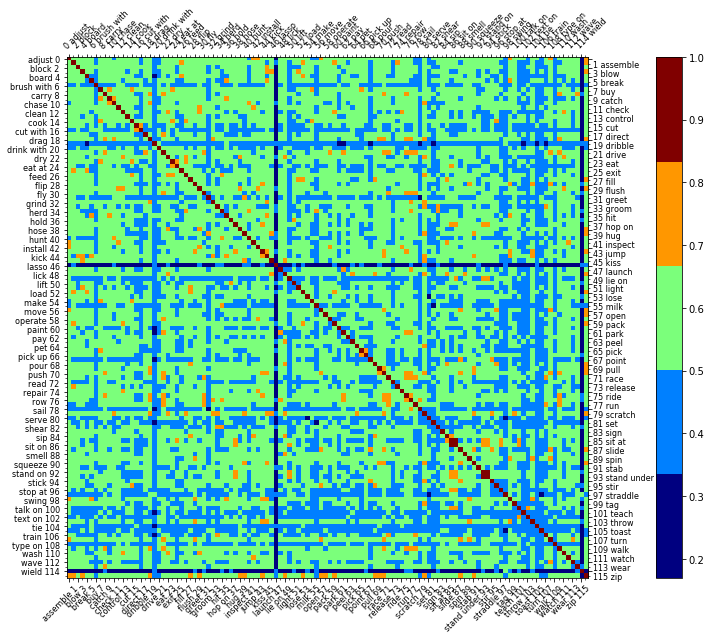

In [3]:
act_index = {}
for i, (a, o) in enumerate(fg_hois):
    act_index.setdefault(a, []).append(i)
    
a = 1
print(hh.actions[a])
embs_a = sentence_act_embs[np.array(act_index[a]), :]
print(embs_a @ embs_a.t())

act_embs = []
for a in range(1, hh.num_actions):
    act_embs.append(sentence_act_embs[np.array(act_index[a]), :].mean(dim=0))
act_embs = torch.stack(act_embs, dim=0)

plot_mat((act_embs @ act_embs.t()).numpy(), 
         xticklabels=hh.actions[1:], 
         yticklabels=hh.actions[1:],
         zero_color=[1, 1, 1],
         bin_colours=True)